In [1]:
all_snrs = {}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

CIIexps = {}

In [100]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
FYST = p.FYST
LADUMA = p.LADUMA

TIM.Daz = 10 * u.deg
TIM.Del = 10 * u.deg
# TIM.SW.dnu = TIM.SW.dnu
# TIM.LW.dnu = TIM.LW.dnu
# TIM.SW.NEI = 7.9e6 * u.Jy * u.s**0.5
# TIM.LW.NEI = 3.2e6 * u.Jy * u.s**0.5
TIM.SW.NEI = .17e6 * u.Jy * u.s**0.5
TIM.LW.NEI = .13e6 * u.Jy * u.s**0.5
mirror_ratio = 1 # 2 m to 50 cm
for band in ['SW', 'LW']:
    TIM[band].ins = ut.Instrument(TIM[band].NEI, TIM[band].FWHM * mirror_ratio, \
            TIM[band].dnu, TIM[band].num_dets)
TIM.time = 1000 * u.hr

In [101]:
def Pn_single(NEI, t_surv, N_spax, z, Daz, Del, dnuFWHM, nu_rest):
    A_surv = (Daz * Del).to(u.sr).value
    dnu = dnuFWHM / np.sqrt(8 * np.log(2))
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    Pn = NEI**2 / t_surv / N_spax * chi**2 * dchi_dnu * A_surv * dnu
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [102]:
Pn_single(TIM.LW.NEI, TIM.time, TIM.LW.num_dets, 1.3, TIM.Daz, TIM.Del, TIM.LW.dnu, l.CII.nu)

381356047.7131284

In [103]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bands = ['SW', 'SW', 'LW', 'LW']

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/2140040013.py:19: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/2140040013.py:36: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/2140040013.py:37: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/2140040013.py:38: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [104]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [TIM[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [TIM[band].min for band in bands]
insmaxs = [TIM[band].max for band in bands]
insdnu = [TIM[band].dnu for band in bands]
linenu = l.CII.nu
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu in zip(CALCZs, insdnu)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax in zip(CALCZs, insmins, insmaxs)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

In [105]:
import pickle
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

In [106]:
KSs = [data['k'] for data in datas]
psCIIs = [data['ps_cii'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIs]

In [107]:
binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

Pns = [Pn_single(TIM[band].NEI, TIM.time, TIM[band].num_dets, CALCZ, TIM.Daz, TIM.Del, TIM[band].dnu, l.CII.nu) for CALCZ, band in zip(CALCZs, bands)]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

# count 1 if all components are non-zero, 0 otherwise
Nmodes_Z = [np.array([np.sum((kxs[i].flat[binnedidxs[i] == j] != 0) & (kys[i].flat[binnedidxs[i] == j] != 0) & (kzs[i].flat[binnedidxs[i] == j] != 0)) \
    for j in range(len(kbinedges[i]) - 1)]) for i in range(len(binnedidxs))]

[-1.00001  -0.900009 -0.800008 -0.700007 -0.600006 -0.500005 -0.400004
 -0.300003 -0.200002 -0.100001  0.        0.100001  0.200002  0.300003
  0.400004  0.500005  0.600006  0.700007  0.800008  0.900009  1.00001 ]
0.100001


/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/4180358267.py:22: RuntimeWarning: divide by zero encountered in log10
  ax1.imshow(np.log10(Nmodes_kmu_ones)[2], origin='lower', aspect='auto',
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/4180358267.py:24: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(Nmodes_kmu_Z)[2], origin='lower', aspect='auto',


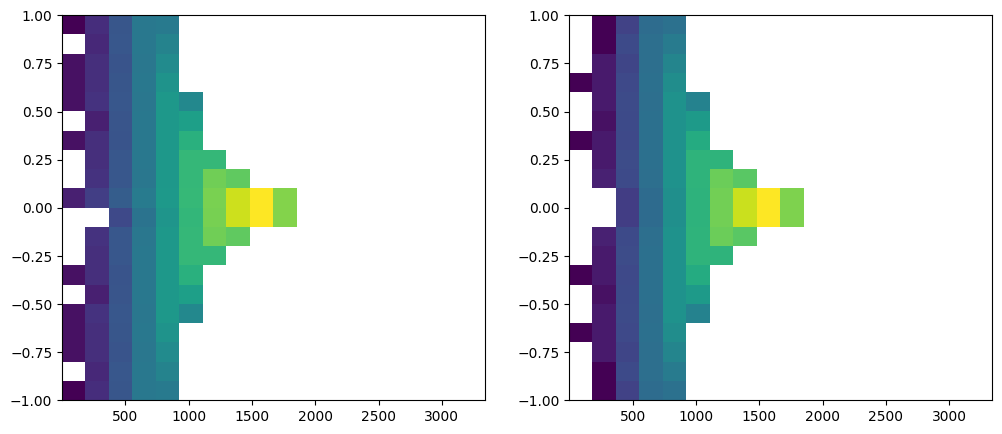

In [108]:
# make a 2D grid of Nmodes in (k_mag, mu) space
mubins = np.linspace(-1 - 1e-5, 1 + 1e-5, 21)
print(mubins)
print(mubins[1]-mubins[0])
binnedidxs_mu = [np.digitize(mu_i.flat, mubins) - 1 for mu_i in mu]
Nmodes_kmu_ones = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    # & (kxs[i].flat != 0)
    # & (kys[i].flat != 0)
    # & (kzs[i].flat != 0)
    )
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]
Nmodes_kmu_Z = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    & (kxs[i].flat != 0)
    & (kys[i].flat != 0)
    & (kzs[i].flat != 0)
    )
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(np.log10(Nmodes_kmu_ones)[2], origin='lower', aspect='auto',
        extent=[kbinedges[2][0], kbinedges[2][-1], mubins[0], mubins[-1]], cmap='viridis')
ax2.imshow(np.log10(Nmodes_kmu_Z)[2], origin='lower', aspect='auto',
        extent=[kbinedges[2][0], kbinedges[2][-1], mubins[0], mubins[-1]], cmap='viridis')
plt.show()
plt.close()

In [109]:
Nmodes_Z[0], np.sum(Nmodes_kmu_Z[0], axis=0)

(array([       0,       72,      744,     7024,    44656,   185264,
          746760,  2989048, 11935720, 39258104,  3782464,        0,
               0,        0,        0,        0,        0,        0]),
 array([       0,       72,      744,     7024,    44656,   185264,
          746760,  2989048, 11935720, 39258104,  3782464,        0,
               0,        0,        0,        0,        0,        0]))

In [110]:
Nmodes_ones[0], np.sum(Nmodes_kmu_ones[0], axis=0)

(array([      16,      150,     1044,     8328,    48028,   192980,
          768836,  3059604, 12183196, 40007392,  3849976,        0,
               0,        0,        0,        0,        0,        0]),
 array([      16,      150,     1044,     8328,    48028,   192980,
          768836,  3059604, 12183196, 40007392,  3849976,        0,
               0,        0,        0,        0,        0,        0]))

In [111]:
# Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(psCII + Pn) ** 2 / Nmode for psCII, Pn, Nmode in zip(psCIIsmedian, Pns, Nmodes_ones)]
Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_88295/332374448.py:3: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)]


In [112]:
# CIIexps['PTIM_1'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'TIM 1 $\deg^2$, 200 hours')
# CIIexps['PTIM_1_Nmodes_ones'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_ones, Pns, binned_wbeams, binned_whpfs, r'TIM 1 $\deg^2$, 200 hours, nmodes one')
# CIIexps['PTIM_p2'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'TIM .2 $\deg^2$, 200 hours')
# CIIexps['TIM_NG'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'TIM NG 4 $\deg^2$, 200 hours')
# CIIexps['TIM_NG_9'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'TIM NG 9 $\deg^2$, 200 hours')
# CIIexps['SpTIM_4'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM lite 4 $\deg^2$, 100 hours')
# CIIexps['SpTIM_9'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM lite 9 $\deg^2$, 100 hours')
# CIIexps['SpTIM_100'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'SpTIM 100 $\deg^2$, 1000 hours')
# CIIexps['SpTIMdeep'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM deep 1 $\deg^2$, 1000 hours')

In [113]:
# CIIexps['PTIM_1'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'TIM 1 $\deg^2$, 200 hours')
# CIIexps['TIM_NG'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'TIM NG 4 $\deg^2$, 200 hours')
CIIexps['SpTIM_100'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'SpTIM 100 $\deg^2$, 1000 hours')

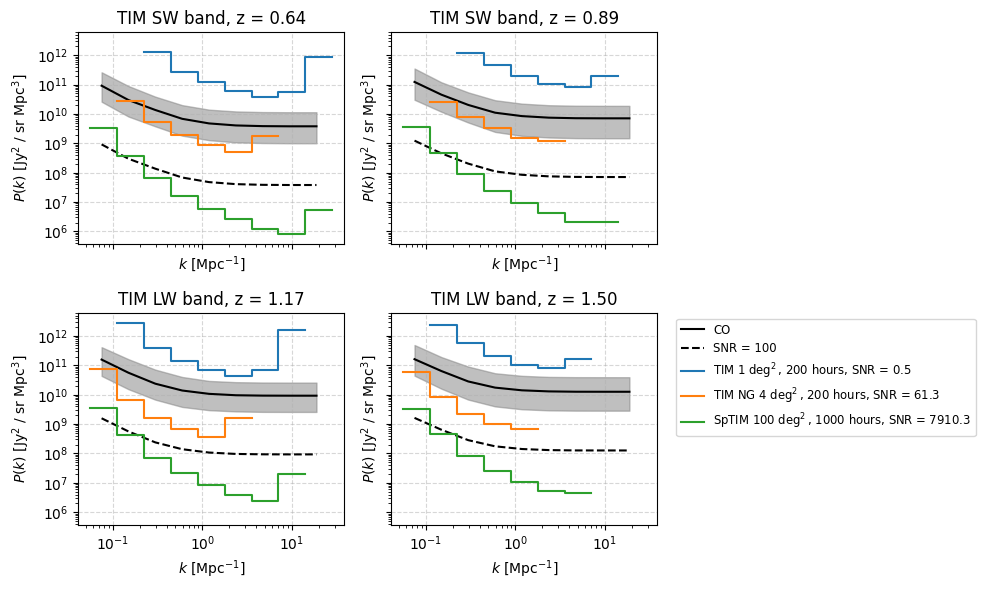

In [114]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCIIsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in CIIexps.values():
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label+f', SNR = {np.nansum(SNR):.1f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [115]:
import pickle

with open('CIIexps.pkl', 'wb') as f:
    pickle.dump(CIIexps, f)

In [117]:
with open('CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
print(CIIexps.keys())

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

COexps = {}

In [8]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

FYST = p.FYST
TIM = p.TIM

FPI_factor = 42
#42 # 315-210 / 2.6
OT_factor = 1 #7 / 2

TIM.Daz = 2 * u.deg
TIM.Del = 2 * u.deg
print(FYST.nbeams)
FYST.time = 2000 * u.hr / FPI_factor * OT_factor

print(f"{FYST.CO43.NEI.to(u.Jy * u.s**0.5 / u.sr).value / 1e6:.2e} MJy s^{0.5} sr^{-1}")
print(f"{FYST.CO54.NEI.to(u.Jy * u.s**0.5 / u.sr).value / 1e6:.2e} MJy s^{0.5} sr^{-1}")

5529.6
1.51e+00 MJy s^0.5 sr^-1
1.37e+00 MJy s^0.5 sr^-1


In [9]:
def Pn_single(NEI, t_surv, N_spax, z, Daz, Del, dnuFWHM, nu_rest):
    A_surv = (Daz * Del).to(u.sr).value
    dnu = dnuFWHM / np.sqrt(8 * np.log(2))
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    Pn = NEI**2 / t_surv / N_spax * chi**2 * dchi_dnu * A_surv * dnu
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [10]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bands = ['CO43', 'CO43', 'CO54', 'CO54']

LSbins = [ut.Survey(b, FYST[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59606/2352813908.py:20: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59606/2352813908.py:37: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59606/2352813908.py:38: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59606/2352813908.py:39: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [11]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [FYST[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [FYST[band].min for band in bands]
insmaxs = [FYST[band].max for band in bands]
insdnus = [FYST.dnu for band in bands]
linenus = [l.CO43.nu, l.CO43.nu, l.CO54.nu, l.CO54.nu]
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu, linenu in zip(CALCZs, insdnus, linenus)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax, linenu in zip(CALCZs, insmins, insmaxs, linenus)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

In [12]:
import pickle
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCOs = [data['ps_co'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCOsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCOs]

binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

FYST_NEIs = [FYST[band].NEI for band in bands]
Pns = [Pn_single(FYST_NEI * u.sr, FYST.time, FYST.nbeams, CALCZ, TIM.Daz, TIM.Del, FYST.dnu, linenu) for CALCZ, linenu, FYST_NEI in zip(CALCZs, linenus, FYST_NEIs)]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

# count 1 if all components are non-zero, 0 otherwise
Nmodes_Z = [np.array([np.sum((kxs[i].flat[binnedidxs[i] == j] != 0) & (kys[i].flat[binnedidxs[i] == j] != 0) & (kzs[i].flat[binnedidxs[i] == j] != 0)) \
    for j in range(len(kbinedges[i]) - 1)]) for i in range(len(binnedidxs))]

/Users/shubh/miniconda3/envs/lim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shubh/miniconda3/envs/lim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
# make a 2D grid of Nmodes in (k_mag, mu) space
mubins = np.linspace(-1 - 1e-5, 1 + 1e-5, 21)
print(mubins)
print(mubins[1]-mubins[0])
binnedidxs_mu = [np.digitize(mu_i.flat, mubins) - 1 for mu_i in mu]
Nmodes_kmu_ones = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    # & (kxs[i].flat != 0)
    # & (kys[i].flat != 0)
    # & (kzs[i].flat != 0)
    )
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]
Nmodes_kmu_Z = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    & (kxs[i].flat != 0)
    & (kys[i].flat != 0)
    & (kzs[i].flat != 0)
    )
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]

[-1.00001  -0.900009 -0.800008 -0.700007 -0.600006 -0.500005 -0.400004
 -0.300003 -0.200002 -0.100001  0.        0.100001  0.200002  0.300003
  0.400004  0.500005  0.600006  0.700007  0.800008  0.900009  1.00001 ]
0.100001


In [14]:
# Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(ps + Pn) ** 2 / Nmode for ps, Pn, Nmode in zip(psCOsmedian, Pns, Nmodes_ones)]
Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59606/1886874112.py:3: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]


In [15]:
# COexps['EoRSpec_lite'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 100 hours')
# COexps['EoRSpec_p2'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 0.2 $\deg^2$, 200 hours')
# COexps['EoRSpec_deep'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 2000 hours')
# COexps['EoRSpec_wide'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 100 $\deg^2$, 4000 hours')
# COexps['EoRSpec_DSS_TIM'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 500 hours')
# COexps['EoRSpec_DSS'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 4 $\deg^2$, 2000 hours')

In [16]:
# COexps['EoRSpec_DSS_TIM'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 500 hours')
# COexps['EoRSpec_DSS'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 4 $\deg^2$, 2000 hours')
# COexps['EoRSpec_wide'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 100 $\deg^2$, 4000 hours')

In [17]:
COexps['FullDSS-EoRSpec'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'DSS-EoRSpec 4 $\deg^2$, 2000 hours')
# COexps['7OT-EoRSpec'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'7OT-EoRSpec 4 $\deg^2$, 2000 hours')
# COexps['OCS-EoRSpec'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'OCS-EoRSpec 100 $\deg^2$, 2000 hours')

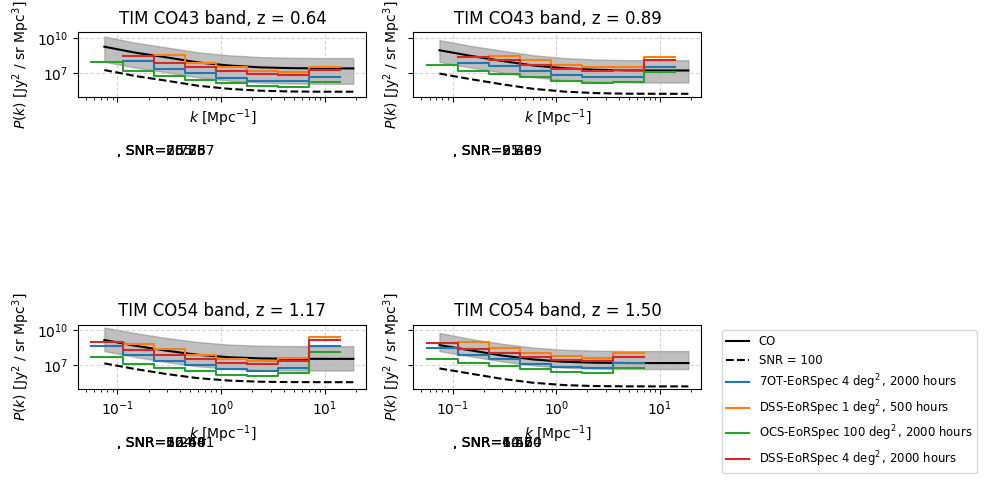

In [18]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCOs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCOs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCOsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCOsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in COexps.values():
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
        ax.text(.1, 1, f', SNR={np.nansum(SNR):.2f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [19]:
with open('./COexps.pkl', 'wb') as f:
    pickle.dump(COexps, f)

In [21]:
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(COexps.keys())

dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [22]:
print(f"{6912 * 0.8 / 42 * 500: .2e}")
print(f"{6912 * 0.8 * 3.5 / 42 * 2000: .2e}")
print(f"{400*3*7 * 0.8 * 2000: .2e}")

 6.58e+04
 9.22e+05
 1.34e+07


In [4]:
import pickle
cross_exps = {}
with open('./outs/CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])
dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [5]:
combos = [
    ('PTIM_1', 'DSS-EoRSpec'),
    ('TIM_NG', '7OT-EoRSpec'),
    ('SpTIM_100', 'OCS-EoRSpec')]

bands = ['SW', 'LW', 'SW', 'LW']

import pickle
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_ciixco'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

In [6]:
for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/3166113335.py:7: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


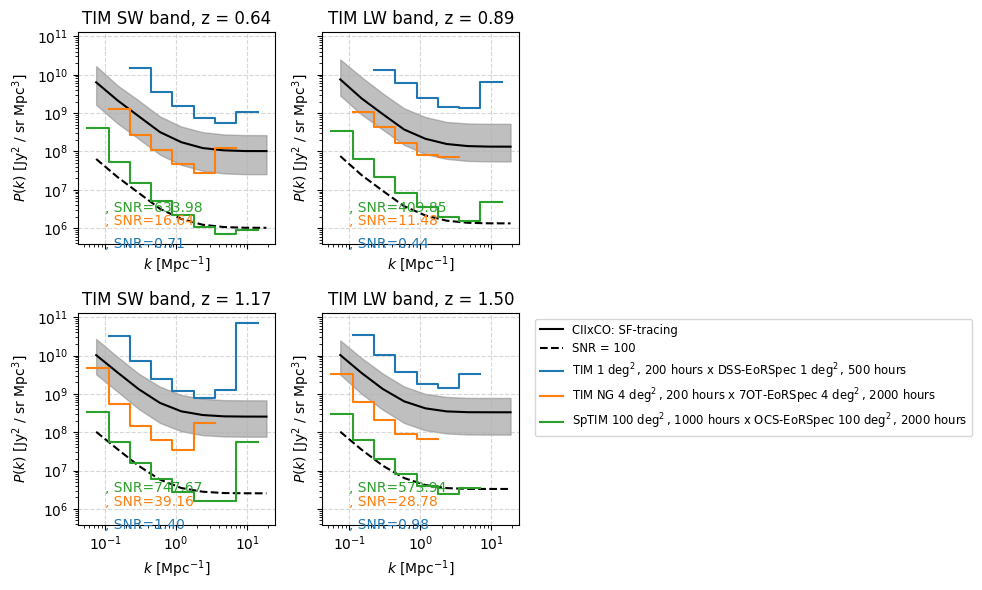

In [7]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxCO: SF-tracing')
    
    # ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    # ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
        ax.text(.1, 3e5*(j+1)**2, f', SNR={np.nansum(SNR):.2f}', color=f'C{j}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/1900167228.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


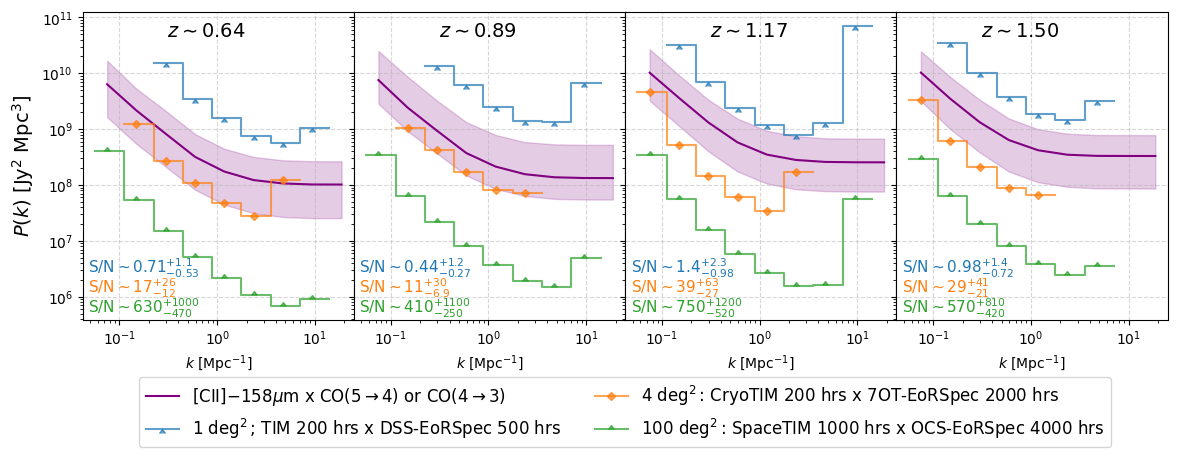

In [28]:

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'purple'
markers = [6, 'D', 10]

# 'DSS-EoRSpec', '7OT-EoRSpec', 'OCS-EoRSpec'
# labels = [
#     r"1 $\deg^2$; TIM 200 hrs x EoRSpec 500 hrs",
#     r"4 $\deg^2$: CryoTIM 200 hrs x EoRSpec 2000 hrs",
#     r"100 $\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs"
# ]
labels = [
    r"1 $\deg^2$; TIM 200 hrs x DSS-EoRSpec 500 hrs",
    r"4 $\deg^2$: CryoTIM 200 hrs x 7OT-EoRSpec 2000 hrs",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x OCS-EoRSpec 4000 hrs"
]

for ax in axs:
    ax.set_xscale('log') 
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]', fontsize=14)

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR, label=r'[CII]$-$158$\mu$m x CO($5\rightarrow 4$) or CO($4\rightarrow 3$)') 
        
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], marker=markers[j], markersize=4, alpha=0.7)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s > 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        # all_snrs["CIIxCO" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
        
        snrtext = r'S/N$\sim$' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        ax.text(.02, .15-.065*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
    ax.text(.6, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(2, -.16), loc='upper center', fontsize=12, ncol=2)

plt.savefig("../figs/preds/CIIxCO_preds.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

HIexps = {}

In [33]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
LADUMA = p.LADUMA

TIM.Daz = 1 * u.deg
TIM.Del = 1 * u.deg
LADUMA.time = 1000 * u.hr

In [34]:
nuz_unscaled = 0.00011029437556268348 / u.m**2 # MeerKAT
# nuz_unscaled = 0.0007642620367272814 / u.m**2 # SKA-MID
# nuz_unscaled = 1.0823287747453567e-05 / u.m**2

In [35]:
def Pn_interf(Tsys, t_surv, n_uz_unscaled, z, Daz, Del, dnuFWHM, nu_rest, Adish):
    # Tsys = Adish / (6.22 * u.m**2 / u.K) 
    A_surv = (Daz * Del).to(u.sr).value
    # dnu = dnuFWHM / np.sqrt(8 * np.log(2)), should just cancel out
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    lambdaobs = (cst.c / nu_rest * (1 + z)).to(u.m)
    FOV = (lambdaobs**2 / Adish).to('').value
    if FOV > A_surv:
        print(f'Warning: FOV {FOV:.2e} > A_surv {A_surv:.2e}, setting FOV = A_surv')
        A_surv = FOV
    n_uz = n_uz_unscaled * lambdaobs**2
    conv = 2 * Tsys * cst.k_B / Adish / np.sqrt(2 * t_surv)
    # conv = 2 * Tsys * cst.k_B / lambdaobs**2 / np.sqrt(2 * dnu * t_surv)
    # conv = Tsys / np.sqrt(2 * dnu * t_surv)
    Pn = conv**2 / n_uz * chi**2 * dchi_dnu * A_surv / FOV
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [36]:
Pn_interf(LADUMA.Tsys, LADUMA.time, nuz_unscaled, 1.5, TIM.Daz, TIM.Del, LADUMA.dnu, l.HI.nu, LADUMA.Adish)

219968.06826781124

In [37]:
def interf_kmodes(z, Adish, maxbaseline, az, el, dnu):
    lambdaobs = (l.HI.l * (1 + z.center)).to(u.m)
    FOV = (lambdaobs**2 / Adish).to('').value
    if FOV > (TIM.Daz * TIM.Del).to(u.sr).value:
        print(f'Warning: FOV {FOV:.2e} > A_surv {(TIM.Daz * TIM.Del).to(u.sr).value:.2e}, setting az, el = sqrt(FOV)')
        az = np.sqrt(FOV) * u.rad
        el = np.sqrt(FOV) * u.rad
    
    Dx = z.transScale(az)
    Dy = z.transScale(el)
    Dz = np.abs(cosmo.comoving_distance(z.front) - cosmo.comoving_distance(z.back))
    FWHM = (lambdaobs / maxbaseline) * u.rad
    
    dchi_dnu = (cst.c / cosmo.H(z.center) * (1 + z.center) ** 2 / l.HI.nu)
    dx = ut.transverse_scale(FWHM, z.center)
    dy = ut.transverse_scale(FWHM, z.center)
    dz = (dchi_dnu * dnu).to(u.Mpc)
    
    kx, ky, kz = np.meshgrid(ut.calc_k_modes(Dx, dx), ut.calc_k_modes(Dy, dy), 
                        ut.calc_k_modes(Dz, dz), indexing='ij')
    
    return np.stack((kx, ky, kz))

In [38]:
interf_kmodes(ut.zBin(TIM.SW.zmin, TIM.SW.zcen), LADUMA.Adish, LADUMA.maxbase, TIM.Daz, TIM.Del, LADUMA.dnu).shape

(3, 167, 167, 972)

In [39]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bands = ['SW', 'SW', 'LW', 'LW']

# LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [np.array(interf_kmodes(b, LADUMA.Adish, LADUMA.maxbase, TIM.Daz, TIM.Del, LADUMA.dnu), dtype=np.float32) for b in bins]
print([kxyzs.shape for kxyzs in k_xyz_modes])
print(k_xyz_modes[0].dtype)
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

# k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
# k_mins = [np.min(km[km != 0]) for km in k_mags]
# k_maxs = [np.max(km) for km in k_mags]
# k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
# k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
# k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]

# kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
# kys = [kxyzs[1] for kxyzs in k_xyz_modes]
# kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

# kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
# kxmaxs = [np.max(abs(kx)) for kx in kxs]
# kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
# kymaxs = [np.max(abs(ky)) for ky in kys]
# kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
# kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = [np.array(kxyzs[2] / np.sqrt(np.sum(kxyzs**2, axis=0)), dtype=np.float32) for kxyzs in k_xyz_modes] #= muz
# mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
# muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

[(3, 167, 167, 972), (3, 167, 167, 737), (3, 167, 167, 744), (3, 167, 167, 562)]
float32


/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_53008/1724154450.py:40: RuntimeWarning: invalid value encountered in divide
  mu = [np.array(kxyzs[2] / np.sqrt(np.sum(kxyzs**2, axis=0)), dtype=np.float32) for kxyzs in k_xyz_modes] #= muz


In [40]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [(l.HI.l * (1 + b.center) / LADUMA.maxbase).to('') * u.rad for b in bins]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [LADUMA.min for band in bands]
insmaxs = [LADUMA.max for band in bands]
insdnus = [LADUMA.dnu for band in bands]
linenus = [l.HI.nu, l.HI.nu, l.HI.nu, l.HI.nu]
CALCZs = [b.center for b in bins]

In [41]:
import gc
sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
wbeamxs = [np.array(wbeam_m(kxyz[0], sigx), dtype=np.float32) for kxyz, sigx in zip(k_xyz_modes, sigxs)]
del sigxs
gc.collect()

sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
wbeamys = [np.array(wbeam_m(kxyz[1], sigy), dtype=np.float32) for kxyz, sigy in zip(k_xyz_modes, sigys)]
del sigys
gc.collect()

sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu, linenu in zip(CALCZs, insdnus, linenus)]
wbeamzs = [np.array(wbeam_m(kxyz[2], sigz), dtype=np.float32) for kxyz, sigz in zip(k_xyz_modes, sigzs)]
del sigzs
gc.collect()
wbeams = [np.array(wbx * wby * wbz, dtype=np.float32) for wbx, wby, wbz in zip(wbeamxs, wbeamys, wbeamzs)]
del wbeamxs, wbeamys, wbeamzs
gc.collect()

0

In [42]:
import gc

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
whpfxs = [np.array(whpf_m(kxyz[0], kminx), dtype=np.float32) for kxyz, kminx in zip(k_xyz_modes, kminxs)]
del kminxs
gc.collect()
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
whpfys = [np.array(whpf_m(kxyz[1], kminy), dtype=np.float32) for kxyz, kminy in zip(k_xyz_modes, kminys)]
del kminys
gc.collect()
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax, linenu in zip(CALCZs, insmins, insmaxs, linenus)]
whpfzs = [np.array(whpf_m(kxyz[2], kminz), dtype=np.float32) for kxyz, kminz in zip(k_xyz_modes, kminzs)]
del kminzs
gc.collect()

whpfs = [np.array(whpx * whpy * whpz, dtype=np.float32) for whpx, whpy, whpz in zip(whpfxs, whpfys, whpfzs)]
del whpfxs, whpfys, whpfzs
gc.collect()

wtotal = [np.array(wb * wh, dtype=np.float32) for wb, wh in zip(wbeams, whpfs)]
del wbeams, whpfs
gc.collect()

0

In [43]:
k_mags = [np.array(np.sqrt(np.sum(kxyzs**2, axis=0)), dtype=np.float32) for kxyzs in k_xyz_modes] 

In [44]:
import pickle
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCOs = [data['ps_hi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCOsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCOs]

binnedidxs = [np.array(np.digitize(km.flat, kbinedge) - 1, dtype=np.int8) for km, kbinedge in zip(k_mags, kbinedges)]

In [45]:
# binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
# binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)], dtype=np.float32) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]
# # del wbeams, whpfs, wtotal
# del wtotal
# gc.collect()

Pns = [Pn_interf(LADUMA.Tsys, LADUMA.time, nuz_unscaled, CALCZ, TIM.Daz, TIM.Del, LADUMA.dnu, l.HI.nu, LADUMA.Adish) for CALCZ in CALCZs]

# Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
# Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

# count 1 if all components are non-zero, 0 otherwise
Nmodes_Z = [np.array([np.sum((k_xyz_modes[i][0].flat[binnedidxs[i] == j] != 0) & 
                            (k_xyz_modes[i][1].flat[binnedidxs[i] == j] != 0) & (k_xyz_modes[i][2].flat[binnedidxs[i] == j] != 0)) \
    for j in range(len(kbinedges[i]) - 1)]) for i in range(len(binnedidxs))]

In [46]:
# make a 2D grid of Nmodes in (k_mag, mu) space
mubins = np.linspace(-1 - 1e-5, 1 + 1e-5, 21)
print(mubins)
print(mubins[1]-mubins[0])
binnedidxs_mu = [np.array(np.digitize(mu_i.flat, mubins) - 1, dtype=np.int32) for mu_i in mu]
# Nmodes_kmu_ones = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m),
#     # & (kxs[i].flat != 0)
#     # & (kys[i].flat != 0)
#     # & (kzs[i].flat != 0)
#     dtype=np.int32)
#     for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
#     for i in range(len(binnedidxs))]
Nmodes_kmu_Z = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    & (k_xyz_modes[i][0].flat != 0)
    & (k_xyz_modes[i][1].flat != 0)
    & (k_xyz_modes[i][2].flat != 0),
    dtype=np.int32)
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]

[-1.00001  -0.900009 -0.800008 -0.700007 -0.600006 -0.500005 -0.400004
 -0.300003 -0.200002 -0.100001  0.        0.100001  0.200002  0.300003
  0.400004  0.500005  0.600006  0.700007  0.800008  0.900009  1.00001 ]
0.100001


In [47]:
# Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(ps + Pn) ** 2 / Nmode for ps, Pn, Nmode in zip(psCOsmedian, Pns, Nmodes_ones)]
Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_53008/1886874112.py:3: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]


In [48]:
# HIexps['MeerKAT_1_100'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 100 hours')
# HIexps['MeerKAT_1_500'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 500 hours')
# HIexps['MeerKAT_1_2000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 2000 hours')
# HIexps['MeerKAT_1_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 2000 hours')
# HIexps['MeerKAT_4_2000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_Z, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 4 $\deg^2$, 2000 hours')
# HIexps['MeerKAT_4_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 4 $\deg^2$, 5000 hours')
# HIexps['SKA-Mid_100_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_Z, Pns, None, None, r'SKA-Mid 100 $\deg^2$, 5000 hours')
# HIexps['MeerKAT_100_10000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, None, None, r'MeerKAT 100 $\deg^2$, 10000 hours')
# HIexps['MeerKAT_100_50000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, None, None, r'MeerKAT 100 $\deg^2$, 50000 hours')

In [51]:
HIexps['MeerKAT_1_1000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, None, None, r'MeerKAT 1 $\deg^2$, 1000 hours')
# HIexps['MeerKAT_4_3000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, None, None, r'MeerKAT 4 $\deg^2$, 3000 hours')
# HIexps['SKA-Mid_100_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, None, None, r'SKA-Mid 100 $\deg^2$, 5000 hours')

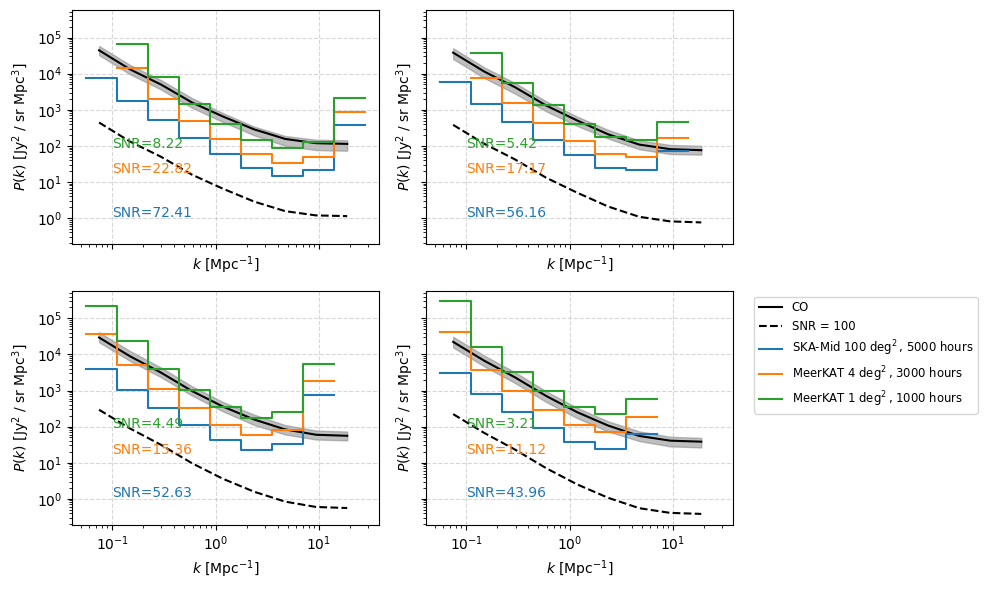

In [52]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCOs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCOs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCOsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCOsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for j, exp in enumerate(HIexps.values()):
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCOsmedian[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label, color=f'C{j}')
        ax.text(.1, 1.1*(j+1)**4, f'SNR={np.nansum(SNR):.2f}', color=f'C{j}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [53]:
#save to csv
# np.savetxt('./forjames.csv', np.array([KSs[0][1:-1], psCOsmedian[0], Pstd[0]]).T, delimiter=',', header='k, P(k), sigma_P(k)', comments='')

In [54]:
import pickle
with open('HIexps.pkl', 'wb') as f:
    pickle.dump(HIexps, f)

In [55]:
(((2 * cst.k_B * 1 * u.mK) ** 2 / (l.HI.l * (1+.4))**4) / u.Jy**2).decompose()

<Quantity 1020.55692752>

In [56]:
import pickle
with open('HIexps.pkl', 'rb') as f:
    HIexps = pickle.load(f)
print(HIexps.keys())

dict_keys(['SKA-Mid_100_5000', 'MeerKAT_4_3000', 'MeerKAT_1_1000'])


In [42]:
import pickle
with open('./outs/CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)
with open('./outs/HIexps.pkl', 'rb') as f:
    HIexps = pickle.load(f)

lineexps = COexps
filename = "../figs/preds/CO_auto.pdf"
ps = "ps_co"
PSCOLOR = 'brown' #'crimson' 'brown' midnightblue
print(lineexps.keys())

dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [43]:
import numpy as np

combos = {"ps_cii": ['PTIM_1', 'TIM_NG', 'SpTIM_100'],
        "ps_hi": ['MeerKAT_1_1000', 'MeerKAT_4_3000', 'SKA-Mid_100_5000'],
        #   "ps_co": ['EoRSpec_DSS_TIM', 'EoRSpec_DSS', 'EoRSpec_PLUS_wide']}[ps]
        "ps_co": ['DSS-EoRSpec', '7OT-EoRSpec', 'OCS-EoRSpec']}[ps]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psauto = [data[ps] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psautomedian = [np.median(pscii, axis=0)[1:-1] for pscii in psauto]
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psauto]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psauto]
autoexps = {}

for cii_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = lineexps[cii_key]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_cii]
    Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psautomedian, Pn_cii, binned_total_cii, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    autoexps[f'{cii_key}'] = (KSs, psautomedian, Pstd, Nmodes, Pn_cii, label_cii + ' auto')

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/261397118.py:29: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psautomedian, Pn_cii, binned_total_cii, Nmodes)]


/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/2353233516.py:66: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


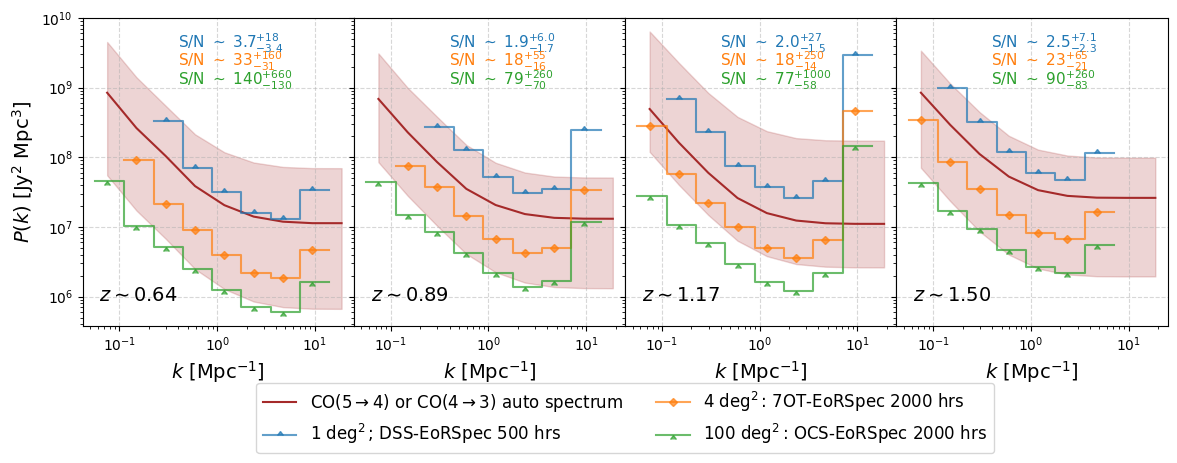

In [47]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
markers = [10, 'D', 6]

# labels = [
#     r"1 $\deg^2$; TIM 200 hrs",
#     r"4 $\deg^2$: CryoTIM 200 hrs",
#     r"100 $\deg^2$: SpaceTIM 1000 hrs"
# ]

# labels = [
#     r"1 $\deg^2$; MeerKAT 1000 hrs",
#     r"4 $\deg^2$: MeerKAT 3000 hrs",
#     r"100 $\deg^2$: SKA-Mid 5000 hrs"
# ]

labels = [
    r"1 $\deg^2$; DSS-EoRSpec 500 hrs",
    r"4 $\deg^2$: 7OT-EoRSpec 2000 hrs",
    r"100 $\deg^2$: OCS-EoRSpec 2000 hrs"
]

# autolabel = 'HI 21 cm auto spectrum'
# autolabel = r'[CII]$-158\mu$m auto spectrum'
autolabel = r'CO($5\rightarrow 4$) or CO($4\rightarrow 3$) auto spectrum'

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]', fontsize=14)
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]', fontsize=14)

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psautomedian[i], color=PSCOLOR, label=autolabel)
        
    for j, exp in enumerate(autoexps.values()):
        linestyle = 'solid'
        if i == 3:
            # do not plot MeerKAT curves
            if 'MeerKAT' in labels[j]:
                linestyle = 'dotted'
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
            marker=markers[j], markersize=4, alpha=0.7, color=f'C{j}', linestyle=linestyle)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s > 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        # all_snrs[f"{ps} auto" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
        
        snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        # ax.text(.45, .37-.06*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
        ax.text(.35, .9-.06*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
    ax.text(.35, .08, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(2, -.16), loc='upper center', fontsize=12, ncol=2)

plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [48]:
import pickle
cross_exps = {}
with open('./outs/CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/HIexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])
dict_keys(['SKA-Mid_100_5000', 'MeerKAT_4_3000', 'MeerKAT_1_1000'])


In [49]:
combos = [
    ('PTIM_1', 'MeerKAT_1_1000'),
    ('TIM_NG', 'MeerKAT_4_3000'),
    ('SpTIM_100', 'SKA-Mid_100_5000')]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_ciixhi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    # Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/4191183530.py:27: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


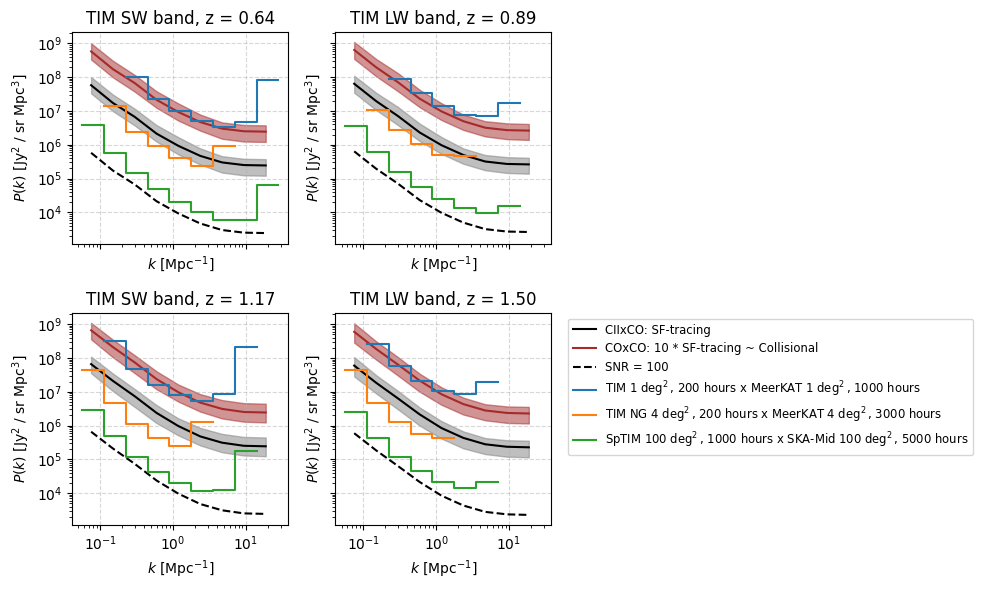

In [50]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxCO: SF-tracing')
    
    ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in cross_exps.values():
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = (psCIIxCOmedian[i] / Pstd_exp[i])
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/4124394280.py:51: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


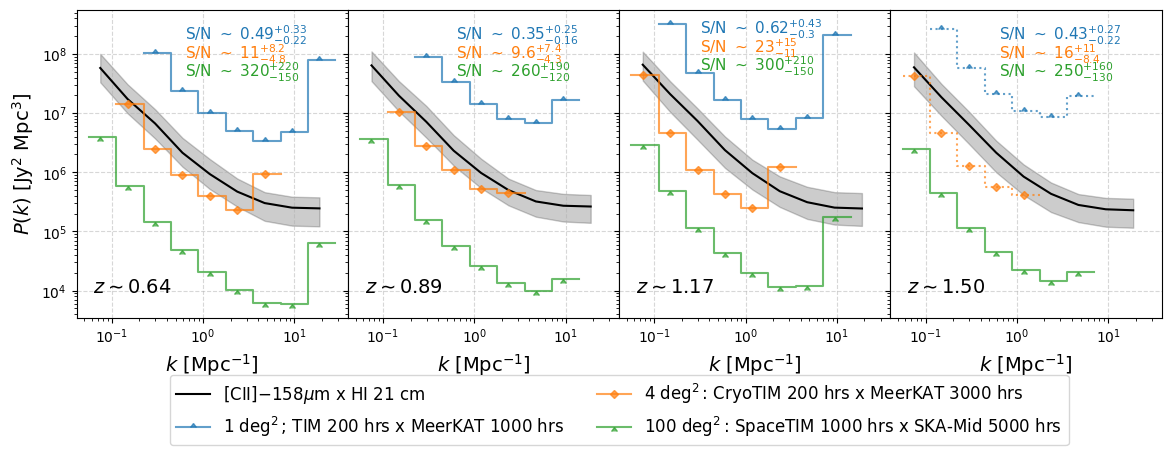

In [60]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'black'
markers = [10, 'D', 6]

labels = [
    r"1 $\deg^2$; TIM 200 hrs x MeerKAT 1000 hrs",
    r"4 $\deg^2$: CryoTIM 200 hrs x MeerKAT 3000 hrs",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x SKA-Mid 5000 hrs"
]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]', fontsize=14)
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]', fontsize=14)

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR, label=r'[CII]$-158\mu$m x HI 21 cm')
        
    for j, exp in enumerate(cross_exps.values()):
        linestyle = 'solid'
        if i == 3:
            # do not plot MeerKAT curves
            if 'MeerKAT' in labels[j]:
                linestyle = 'dotted'
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
            marker=markers[j], markersize=4, alpha=0.7, color=f'C{j}', linestyle=linestyle)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s > 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        # all_snrs[f"CIIxHI" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
        
        snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        if i != 2:
            ax.text(.4, .9-.06*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
        else:
            ax.text(.3, .92-.06*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
    ax.text(.35, .08, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(2, -.16), loc='upper center', fontsize=12, ncol=2)

plt.savefig("../figs/preds/CIIxHI_preds.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [61]:
import pickle
cross_exps = {}
with open('./outs/HIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['SKA-Mid_100_5000', 'MeerKAT_4_3000', 'MeerKAT_1_1000'])
dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [62]:
combos = [
    ('MeerKAT_1_1000', 'DSS-EoRSpec'),
    ('MeerKAT_4_3000', '7OT-EoRSpec'),
    ('SKA-Mid_100_5000', 'OCS-EoRSpec')]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_coxhi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    # Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/1303386305.py:27: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


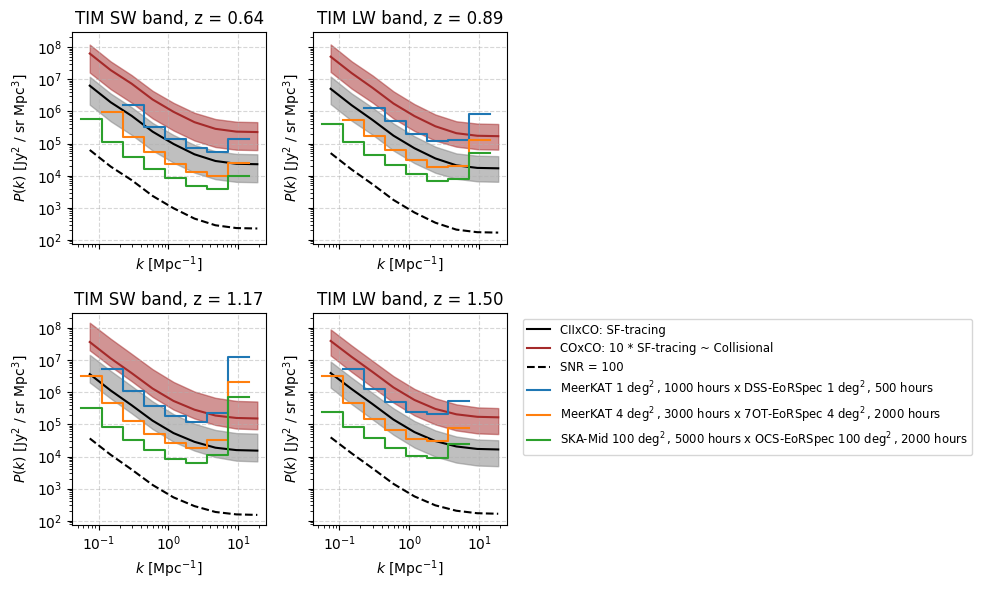

In [63]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxCO: SF-tracing')
    
    ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in cross_exps.values():
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = (psCIIxCOmedian[i] / Pstd_exp[i])
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/422708759.py:52: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


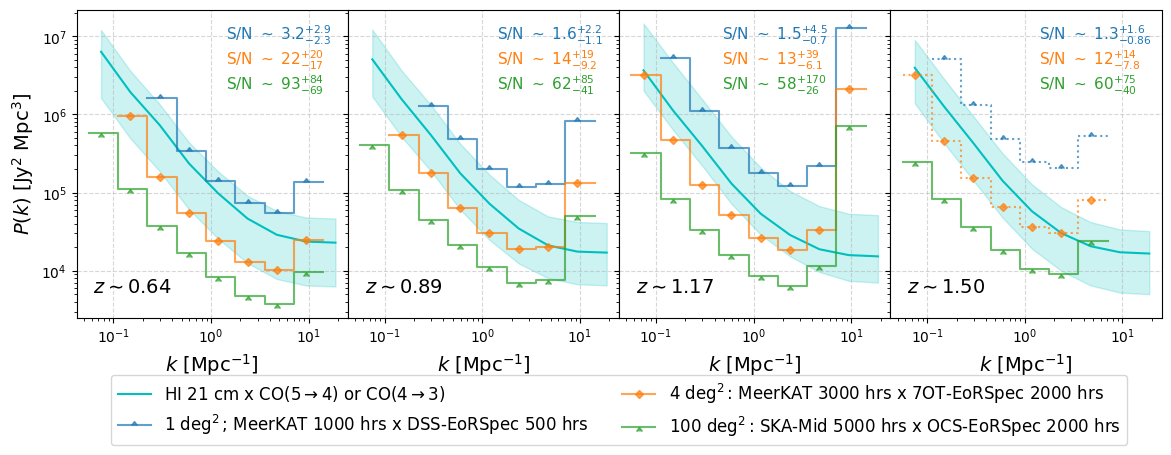

In [67]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'c'
markers = [10, 'D', 6]

labels = [
    r"1 $\deg^2$; MeerKAT 1000 hrs x DSS-EoRSpec 500 hrs",
    r"4 $\deg^2$: MeerKAT 3000 hrs x 7OT-EoRSpec 2000 hrs",
    r"100 $\deg^2$: SKA-Mid 5000 hrs x OCS-EoRSpec 2000 hrs"
]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]', fontsize=14)
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]', fontsize=14)
colors = ['C0', 'C1', 'C2']

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR, label=r'HI 21 cm x CO($5\rightarrow 4$) or CO($4\rightarrow 3$)')
        
    for j, exp in enumerate(cross_exps.values()):
        linestyle = 'solid'
        if i == 3:
            # do not plot MeerKAT curves
            if 'MeerKAT' in labels[j]:
                linestyle = 'dotted'
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
            marker=markers[j], markersize=4, alpha=0.7, color=colors[j], linestyle=linestyle)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s>1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        
        # all_snrs[f"COxHI" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
        if i != 2:
            ax.text(.55, .9-.08*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
        else:
            ax.text(.38, .9-.08*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
    ax.text(.35, .08, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(2, -.16), loc='upper center', fontsize=12, ncol=2)

plt.savefig("../figs/preds/COxHI_preds.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys, pickle

GALexps = {}

In [42]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
TIM.Daz = 10 * u.deg
TIM.Del = 10 * u.deg

In [43]:
def Pn_GAL(num_den):
    return 1 / num_den

In [44]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bands = ['SW', 'SW', 'LW', 'LW']

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_6792/2140040013.py:19: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_6792/2140040013.py:36: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_6792/2140040013.py:37: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_6792/2140040013.py:38: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [45]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [TIM[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [TIM[band].min for band in bands]
insmaxs = [TIM[band].max for band in bands]
insdnus = [TIM[band].dnu for band in bands]
linenu = l.CII.nu
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu in zip(CALCZs, insdnus)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax in zip(CALCZs, insmins, insmaxs)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

In [46]:
import gc
sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
del sigxs
gc.collect()

sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
del sigys
gc.collect()

sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu in zip(CALCZs, insdnus)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
del sigzs
gc.collect()
wbeams = [wbx * wby * wbz for wbx, wby, wbz in zip(wbeamxs, wbeamys, wbeamzs)]
del wbeamxs, wbeamys, wbeamzs
gc.collect()

0

In [47]:
kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
del kminxs
gc.collect()
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
del kminys
gc.collect()
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax in zip(CALCZs, insmins, insmaxs)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
del kminzs
gc.collect()

whpfs = [whpx * whpy * whpz for whpx, whpy, whpz in zip(whpfxs, whpfys, whpfzs)]
del whpfxs, whpfys, whpfzs
gc.collect()

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]
gc.collect()

0

In [48]:
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

ngals = [np.median([data['means_and_densities'][i]['props']['ngal']['density'] \
    for i in range(len(data['means_and_densities']))]) for data in datas]

print(ngals)

KSs = [data['k'] for data in datas]
psCOs = [data['ps_galaxy'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCOsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCOs]

binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

Pns = [Pn_GAL(ngal) for ngal in ngals]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

# count 1 if all components are non-zero, 0 otherwise
Nmodes_Z = [np.array([np.sum((kxs[i].flat[binnedidxs[i] == j] != 0) & (kys[i].flat[binnedidxs[i] == j] != 0) & (kzs[i].flat[binnedidxs[i] == j] != 0)) \
    for j in range(len(kbinedges[i]) - 1)]) for i in range(len(binnedidxs))]

[0.008365300589599486, 0.0060049499982592, 0.004303301897525504, 0.0028856916157278716]


In [49]:
# make a 2D grid of Nmodes in (k_mag, mu) space
mubins = np.linspace(-1 - 1e-5, 1 + 1e-5, 21)
print(mubins)
print(mubins[1]-mubins[0])
binnedidxs_mu = [np.digitize(mu_i.flat, mubins) - 1 for mu_i in mu]
Nmodes_kmu_ones = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    # & (kxs[i].flat != 0)
    # & (kys[i].flat != 0)
    # & (kzs[i].flat != 0)
    )
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]
Nmodes_kmu_Z = [np.array([[np.sum((binnedidxs[i] == j) & (binnedidxs_mu[i] == m)
    & (kxs[i].flat != 0)
    & (kys[i].flat != 0)
    & (kzs[i].flat != 0)
    )
    for j in range(len(kbinedges[i]) - 1)] for m in range(len(mubins) - 1)]) \
    for i in range(len(binnedidxs))]

[-1.00001  -0.900009 -0.800008 -0.700007 -0.600006 -0.500005 -0.400004
 -0.300003 -0.200002 -0.100001  0.        0.100001  0.200002  0.300003
  0.400004  0.500005  0.600006  0.700007  0.800008  0.900009  1.00001 ]
0.100001


In [50]:
# Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(ps + Pn) ** 2 / Nmode for ps, Pn, Nmode in zip(psCOsmedian, Pns, Nmodes_ones)]
Pvar = [(psCII + Pn / 1) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_6792/190590408.py:3: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(psCII + Pn / 1) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]


In [51]:
# GALexps['Euclid_1'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'Euclid 1 $\deg^2$')
# GALexps['Euclid_4'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'Euclid 4 $\deg^2$')
GALexps['Euclid_100'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes_kmu_Z, Pns, binned_wbeams, binned_whpfs, r'Euclid 100 $\deg^2$')


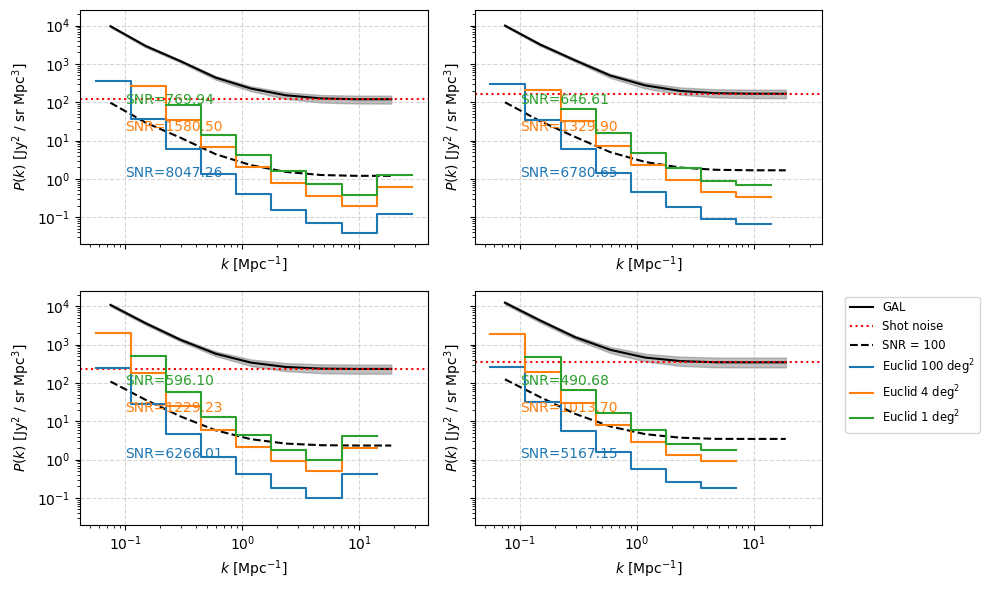

In [52]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCOs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCOs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCOsmedian[i], color='black', label='GAL')
    ax.axhline(Pns[i], color='red', linestyle=':', label='Shot noise')
    
    ax.plot(KSs[i][1:-1], psCOsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for j, exp in enumerate(GALexps.values()):
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCOsmedian[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label, color=f'C{j}')
        ax.text(.1, 1.1*(j+1)**4, f'SNR={np.nansum(SNR):.2f}', color=f'C{j}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [53]:
import pickle
with open('GALexps.pkl', 'wb') as f:
    pickle.dump(GALexps, f)

In [94]:
import pickle
cross_exps = {}

# kind = 'HI'
# kind = 'CO'
kind = 'CII'

with open(f'./outs/{kind}exps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/GALexps.pkl', 'rb') as f:
    GALexps = pickle.load(f)

In [95]:
print(CIIexps.keys())
print(GALexps.keys())
cross_exps = {}

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])
dict_keys(['Euclid_100', 'Euclid_4', 'Euclid_1'])


In [96]:
combos = [
    ('PTIM_1', 'Euclid_1'),
    ('TIM_NG', 'Euclid_4'),
    ('SpTIM_100', 'Euclid_100')]

# combos = [
#     ('DSS-EoRSpec', 'Euclid_1'),
#     ('7OT-EoRSpec', 'Euclid_4'),
#     ('OCS-EoRSpec', 'Euclid_100')]

# combos = [
#     ('PTIM_1', 'Euclid_1'),
#     ('PTIM_1_Nmodes_ones', 'Euclid_1'),
#     ]

# combos = [
#     ('MeerKAT_1_1000', 'Euclid_1'),
#     ('MeerKAT_4_3000', 'Euclid_4'),
#     ('SKA-Mid_100_5000', 'Euclid_100')]

bands = ['SW', 'SW', 'LW', 'LW']

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data[f'ps_cross_{kind.lower()}xgalaxy'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

In [97]:
for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = GALexps[co_key]
    
    # Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    # do not apply window for galaxy survey
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/3949055607.py:9: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


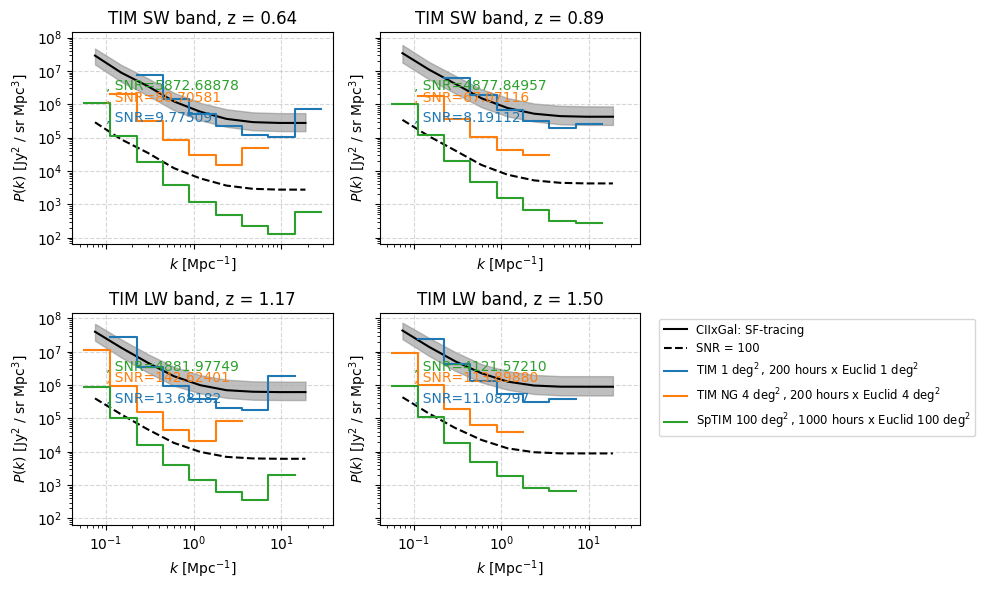

In [98]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxGal: SF-tracing')
    
    # ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    # ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
        ax.text(.1, 3e5*(j+1)**2, f', SNR={np.nansum(SNR):.5f}', color=f'C{j}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90473/437060635.py:66: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


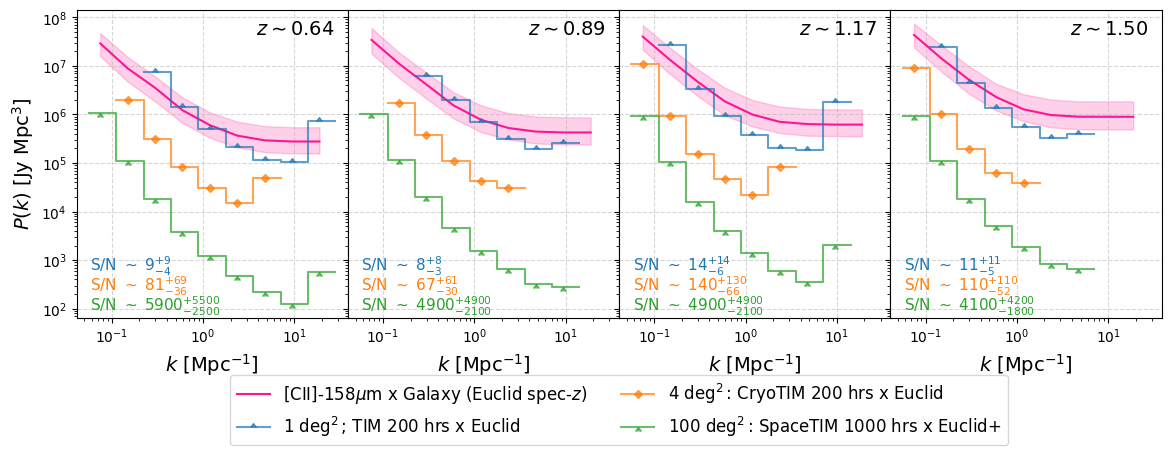

In [100]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = ['cyan', 'deeppink', 'orange']['HI CII CO'.split().index(kind)]
markers = [10, 'D', 6]
linelabel = r'HI 21 cm' if kind == 'HI' else (r'[CII]-158$\mu$m' if kind == 'CII' else r'CO($5\rightarrow4$) or CO($4\rightarrow3$)')

labels = [
    r"1 $\deg^2$; TIM 200 hrs x Euclid",
    r"4 $\deg^2$: CryoTIM 200 hrs x Euclid",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x Euclid+"
]

# labels = [
#     r"1 $\deg^2$; DSS-EoRSpec 500 hrs x Euclid",
#     r"4 $\deg^2$: 7OT-EoRSpec 2000 hrs x Euclid",
#     r"100 $\deg^2$: OCS-EoRSpec 2000 hrs x Euclid+"
# ]

# labels = [
#     r"1 $\deg^2$; MeerKAT 1000 hrs x Euclid",
#     r"4 $\deg^2$: MeerKAT 3000 hrs x Euclid",
#     r"100 $\deg^2$: SKA-Mid 5000 hrs x Euclid+"
# ]

# labels = [
#     r"1 $\deg^2$; PTIM 200 hrs x Euclid",
#     r"1 $\deg^2$; PTIM 200 hrs x Euclid (Nmodes ones)"
# ]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]', fontsize=14)
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy Mpc$^3$]', fontsize=14)

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR, label=linelabel + r' x Galaxy (Euclid spec-$z$)')
        
    for j, exp in enumerate(cross_exps.values()):
        linestyle = 'solid'
        if i == 3:
            # do not plot MeerKAT curves
            if 'MeerKAT' in labels[j]:
                linestyle = 'dotted'
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
            marker=markers[j], markersize=4, alpha=0.7, color=f'C{j}', linestyle=linestyle)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        # all_snrs[f"HIxGAL" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
        
        snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        ax.text(.05, .15-.065*j, snrtext, color=f'C{j}', transform=ax.transAxes, fontsize=11)
    ax.text(.95, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(2, -.16), loc='upper center', fontsize=12, ncol=2)

plt.savefig(f"../figs/preds/{kind}xGal.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [48]:
import pickle
with open('all_snrs.pkl', 'wb') as f:
    pickle.dump(all_snrs, f)

In [36]:
import pickle
with open('./outs/all_snrs.pkl', 'rb') as f:
    all_snrs = pickle.load(f)
all_snrs

{'CIIxCO1 $\\deg^2$; TIM 200 hrs x EoRSpec 500 hrs z=0.64': (8, 6, 14),
 'CIIxCO4 $\\deg^2$: CryoTIM 200 hrs x EoRSpec 2000 hrs z=0.64': (67, 50, 110),
 'CIIxCO100 $\\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs z=0.64': (5100,
  3800,
  8100),
 'CIIxCO1 $\\deg^2$; TIM 200 hrs x EoRSpec 500 hrs z=0.89': (9, 5, 26),
 'CIIxCO4 $\\deg^2$: CryoTIM 200 hrs x EoRSpec 2000 hrs z=0.89': (71, 43, 190),
 'CIIxCO100 $\\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs z=0.89': (5100,
  3000,
  14000),
 'CIIxCO1 $\\deg^2$; TIM 200 hrs x EoRSpec 500 hrs z=1.17': (17, 12, 27),
 'CIIxCO4 $\\deg^2$: CryoTIM 200 hrs x EoRSpec 2000 hrs z=1.17': (150,
  100,
  240),
 'CIIxCO100 $\\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs z=1.17': (5800,
  4100,
  9600),
 'CIIxCO1 $\\deg^2$; TIM 200 hrs x EoRSpec 500 hrs z=1.50': (22, 16, 31),
 'CIIxCO4 $\\deg^2$: CryoTIM 200 hrs x EoRSpec 2000 hrs z=1.50': (180,
  130,
  250),
 'CIIxCO100 $\\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs z=1.50': (7300,
  5300,
  10000),
 '

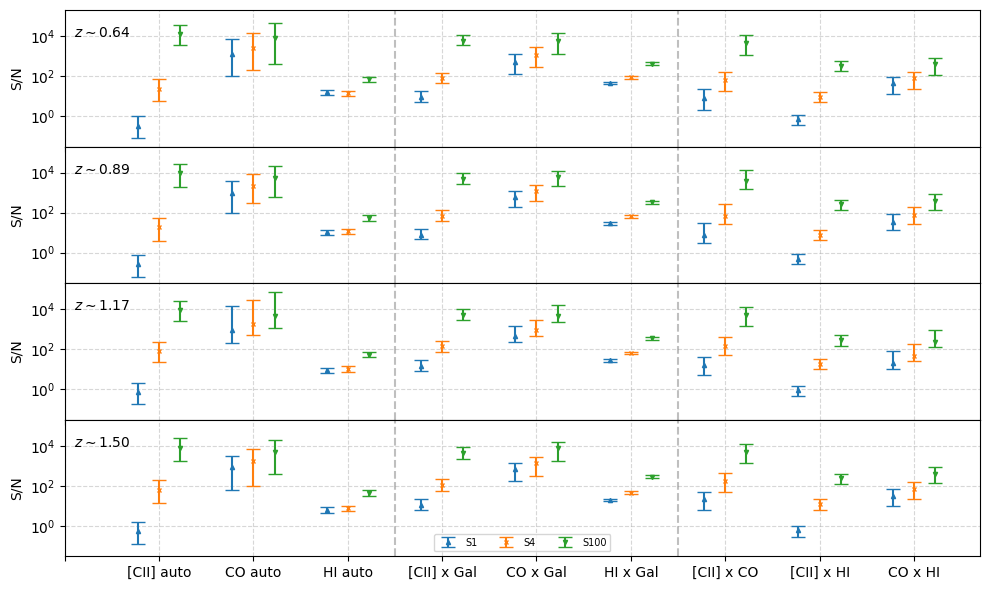

In [49]:
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True, sharey=True, gridspec_kw={'hspace': 0})

xticklabels = ['[CII] auto', 'CO auto', 'HI auto',
            '[CII] x Gal', 'CO x Gal', 'HI x Gal',
            '[CII] x CO', '[CII] x HI', 'CO x HI',]

keys = ["ps_cii auto", "ps_co auto", "ps_hi auto",
        "CIIxGAL", "COxGAL", "HIxGAL",
        "CIIxCO", "CIIxHI", "COxHI"]

sizekeys = ['1', '4', '100']
sizecolors = {'1': 'C0', '4': 'C1', '100': 'C2'}
markers = {'1': '^', '4': 'x', '100': 'v'}

for i, ax in enumerate(axs):
    zkey = f'{Z_MODELING[i]:.2f}'
    snrs, snr_lows, snr_highs = [], [], []
    for key in keys:
        s, sl, sh = {}, {}, {}
        for sizekey in sizekeys:
            for k, v in all_snrs.items():
                if zkey in k and key in k and sizekey + " " in k:
                    s[sizekey], sl[sizekey], sh[sizekey] = v
        snrs.append(s)
        snr_lows.append(sl)
        snr_highs.append(sh)
    
    x = np.arange(len(xticklabels))
    
    for j, sizekey in enumerate(sizekeys):
        snrs_size = [float(snr[sizekey]) for snr in snrs]
        snr_lows_size = [float(snr_low[sizekey]) for snr_low in snr_lows]
        snr_highs_size = [float(snr_high[sizekey]) for snr_high in snr_highs]
        ax.errorbar(x + (j-1)*0.225, snrs_size, yerr=[snr_lows_size, snr_highs_size], \
            fmt=markers[sizekey], color=sizecolors[sizekey], markersize=3, capsize=5)
    
    ax.set_yscale('log')
    ax.set_xticks([-1] + list(x) + [len(xticklabels)])
    ax.set_xticklabels([""] + xticklabels + [""])
    ax.set_ylabel(r'S/N')
    ax.text(.01, .8, r'$z \sim$' + zkey, transform=ax.transAxes, horizontalalignment='left', fontsize=10)
    ax.grid(linestyle='--', alpha=0.5)

    if i == 3:
        ax.legend(['S1', 'S4', 'S100'], fontsize='x-small', ncol=3, loc='lower center')
    
    ax.set_ylim(3e-2, 2e5)
    ax.set_xlim(-1, len(xticklabels)-0.3)
    ax.vlines([2.5, 5.5], 3e-2, 2e5, colors='grey', linestyles='dashed', alpha=0.5)
    
    ax.set_yticks([1e0, 1e2, 1e4], labels=['$10^{0}$', '$10^{2}$', '$10^{4}$'])
    
plt.tight_layout()

plt.savefig("../figs/preds/all_snrs.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()